## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Defining the Problem](#0)
* [2. Importing the Packages and Loading Data](#1)
    * [2.1. Importing the Packages](#1.1)    
    * [2.2. Loading Data](#1.2)
* [3. Discovering and Visualizing the Data to Gain Insights](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualization](#2.2)   
    * [3.3. Time Series Analysis](#2.3)
* [4. Preparing the Data for Machine Learning Algorithms](#3)
* [5. Creating, Compiling, Fitting, and Evaluating the model](#4)        
    * [5.1. Train-Test Split](#4.1)
    * [5.2. Comparing Models and Algorithms](#4.3)
        * [5.2.1 Machine Learning Models - scikit-learn](#4.3.1)
        * [5.2.2 Time Series Based Deep Learning Models - LSTM](#4.3.2)
* [6. Using the Model to Make Predictions](#6)
    * [6.1. Result on the Test Dataset](#6.1)

<a id='0'></a>
# 1. Defining the Problem

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Importing the Packages and Loading Data

<a id='1.1'></a>
## 2.1. Importing the Packages

In [33]:
# Libraries for data preparation and visualization
import numpy as np
import pandas as pd

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import datetime

from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

# Libraries for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Libraries for statistical models
import statsmodels.api as sm

# Libraries for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Libraries for the deep learning models
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading Data

Next, we extract the data required for our analysis using pandas datareader.

In [7]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['^GSPC', '^DJI', '^VIX']
idx_tickers_name = ['SP500', 'DJIA', 'VIXCLS']

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

stk_data = web.get_data_yahoo(stk_tickers, start_date, end_date)
ccy_data = web.get_data_fred(ccy_tickers, start_date, end_date)
idx_data = web.get_data_yahoo(idx_tickers, start_date, end_date)
#idx_data = web.get_data_fred(idx_tickers_name, start_date, end_date)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


In [8]:
stk_data.dropna().head()

Adj Close                            Close                         \
                GOOGL        IBM       MSFT      GOOGL         IBM       MSFT   
Date                                                                            
2010-01-04  15.684434  77.467316  23.474928  15.684434  126.625237  30.950001   
2010-01-05  15.615365  76.531479  23.482500  15.615365  125.095604  30.959999   
2010-01-06  15.221722  76.034340  23.338394  15.221722  124.282982  30.770000   
2010-01-07  14.867367  75.771141  23.095680  14.867367  123.852776  30.450001   
2010-01-08  15.065566  76.531479  23.254959  15.065566  125.095604  30.660000   

                 High                               Low              \
                GOOGL         IBM       MSFT      GOOGL         IBM   
Date                                                                  
2010-01-04  15.753504  127.122368  31.100000  15.621622  125.095604   
2010-01-05  15.711712  126.051628  31.100000  15.554054  124.378586   
2010-01-06  15.662162  125.707458  31.080000  15.174174  124.101341   
2010-01-07  15.265265  124.521988  30.700001  14.831081  123.240921   
2010-01-08  15.096346  125.162521  30.879999  14.742492  123.374763   

                            Open                            Volume           \
                 MSFT      GOOGL         IBM       MSFT      GOOGL      IBM   
Date                                                                          
2010-01-04  30.590000  15.689439  125.411087  30.620001   78169752  6438444   
2010-01-05  30.639999  15.695195  125.889099  30.850000  120067812  7156104   
2010-01-06  30.520000  15.662162  124.933075  30.879999  158988852  5863144   
2010-01-07  30.190001  15.250250  124.158699  30.629999  256315428  6109268   
2010-01-08  30.240000  14.814815  123.393883  30.280001  188783028  4390271   

                      
                MSFT  
Date                  
2010-01-04  38409100  
2010-01-05  49749600  
2010-01-06  58182400  
2010-01-07  50559700  
2010-01-08  51197400

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [9]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

   a. GOOGL 5 Business Day Returns    
   b. IBM 5 Business Day Returns    
   c. USD/JPY 5 Business Day Returns    
   d. GBP/USD 5 Business Day Returns    
   e. S&P 500 5 Business Day Returns    
   f. Dow Jones 5 Business Day Returns    
   g. MSFT 5 Business Day Returns    
   h. MSFT 15 Business Day Returns    
   i. MSFT 30 Business Day Returns    
   j. MSFT 60 Business Day Returns


In [10]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data.loc[:, ('Adj Close', ('^GSPC', '^DJI', '^VIX'))]).diff(return_period)
X3.columns = idx_tickers_name
#X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Discovering and Visualizing the Data to Gain Insights

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [11]:
pd.set_option('display.precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,467.000,467.000,4.670e+02,4.670e+02,4.670e+02,467.000,467.000,4.670e+02,467.000,467.000,467.000,467.000
mean,0.004,0.003,5.337e-04,5.169e-04,-3.069e-04,0.002,0.002,-3.270e-04,0.004,0.011,0.023,0.045
std,0.031,0.035,2.782e-02,1.260e-02,1.116e-02,0.021,0.020,1.670e-01,0.032,0.048,0.065,0.089
min,-0.155,-0.117,-1.080e-01,-3.908e-02,-4.628e-02,-0.117,-0.111,-5.562e-01,-0.155,-0.164,-0.192,-0.237
25%,-0.014,-0.017,-1.333e-02,-6.259e-03,-7.324e-03,-0.007,-0.007,-9.373e-02,-0.013,-0.016,-0.017,-0.012
50%,0.004,0.005,2.686e-03,6.542e-04,-1.853e-04,0.005,0.004,-1.653e-02,0.005,0.013,0.026,0.054
75%,0.023,0.023,1.694e-02,7.826e-03,7.395e-03,0.014,0.012,8.231e-02,0.022,0.042,0.065,0.103
max,0.132,0.174,9.203e-02,5.829e-02,3.733e-02,0.065,0.069,9.601e-01,0.132,0.169,0.231,0.263


In [12]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2010-03-31,0.021,1.741e-02,-0.002,1.630e-02,0.018,0.001,1.888e-03,0.002,-0.012,0.011,0.024,-0.050
2010-04-08,0.031,6.522e-04,-0.005,-7.166e-03,-0.001,0.014,6.467e-03,-0.065,0.021,0.010,0.044,-0.007
2010-04-15,0.017,4.784e-02,0.025,-1.289e-03,0.013,0.021,1.971e-02,-0.036,0.031,0.040,0.081,-0.003
2010-04-22,-0.013,-8.451e-02,-0.014,-3.225e-04,-0.006,-0.002,-9.229e-04,0.036,0.017,0.069,0.080,0.067
2010-04-29,-0.067,-2.792e-02,0.010,1.229e-02,-0.004,-0.002,2.962e-03,0.113,-0.013,0.035,0.045,0.090


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period.

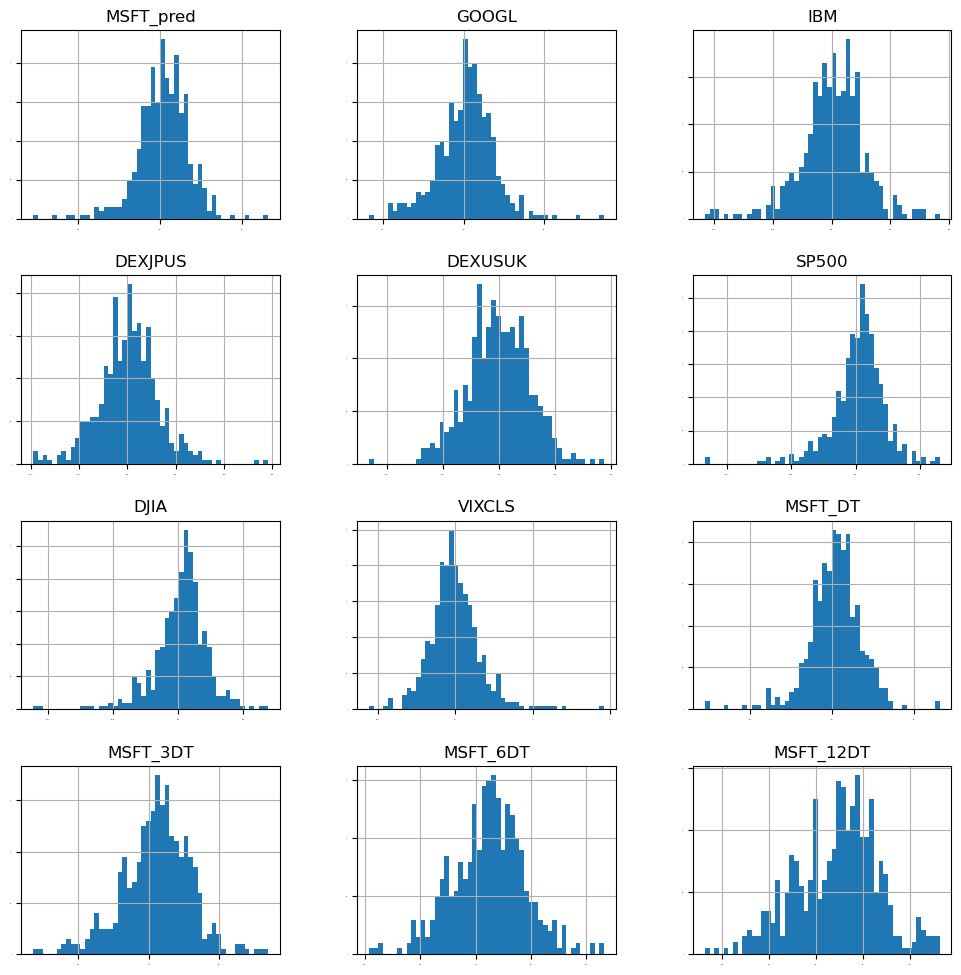

In [13]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix.

<Axes: title={'center': 'Correlation Matrix'}>

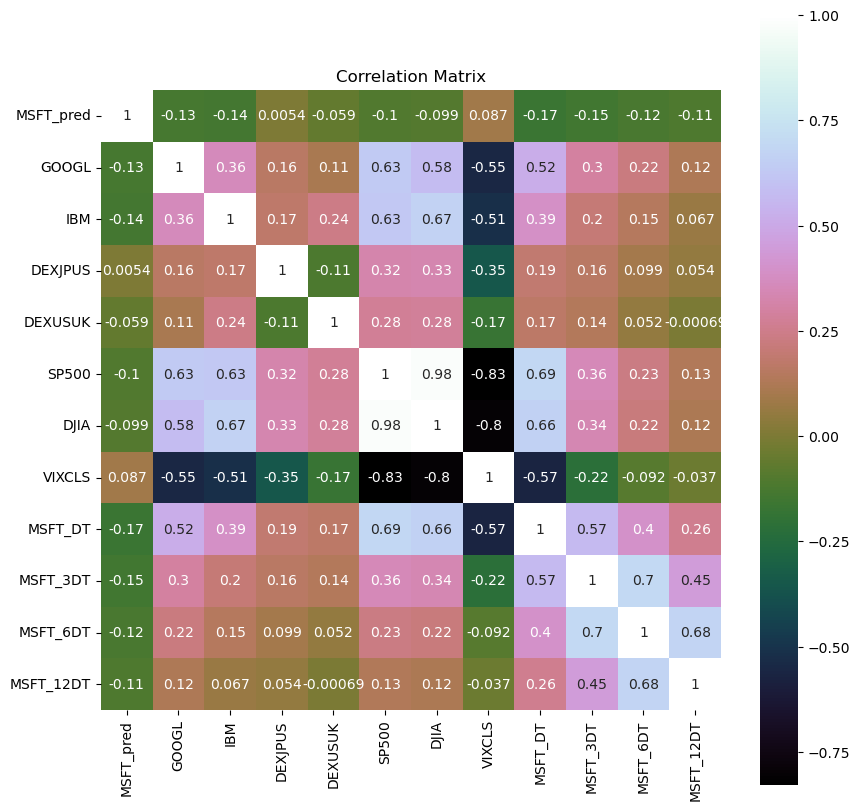

In [14]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

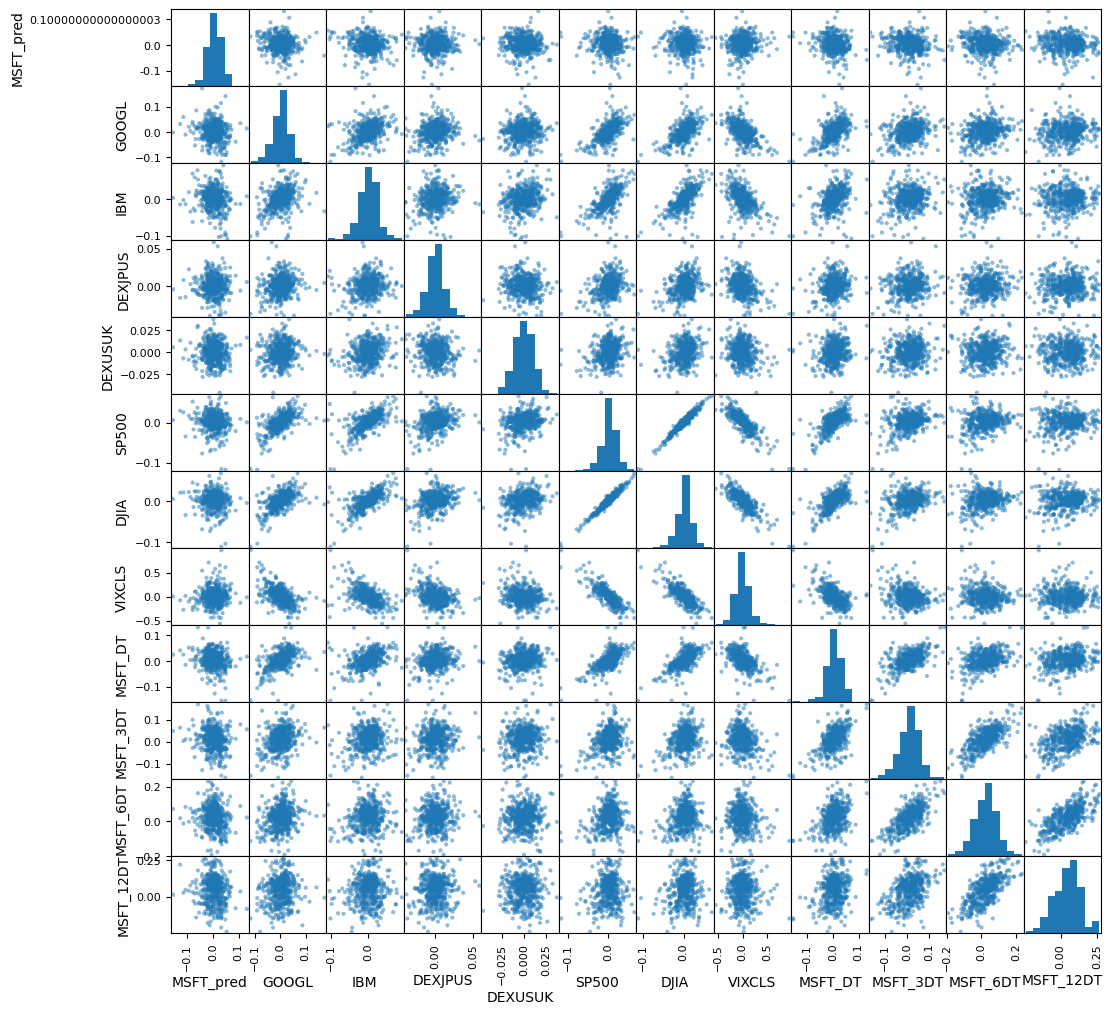

In [15]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series.

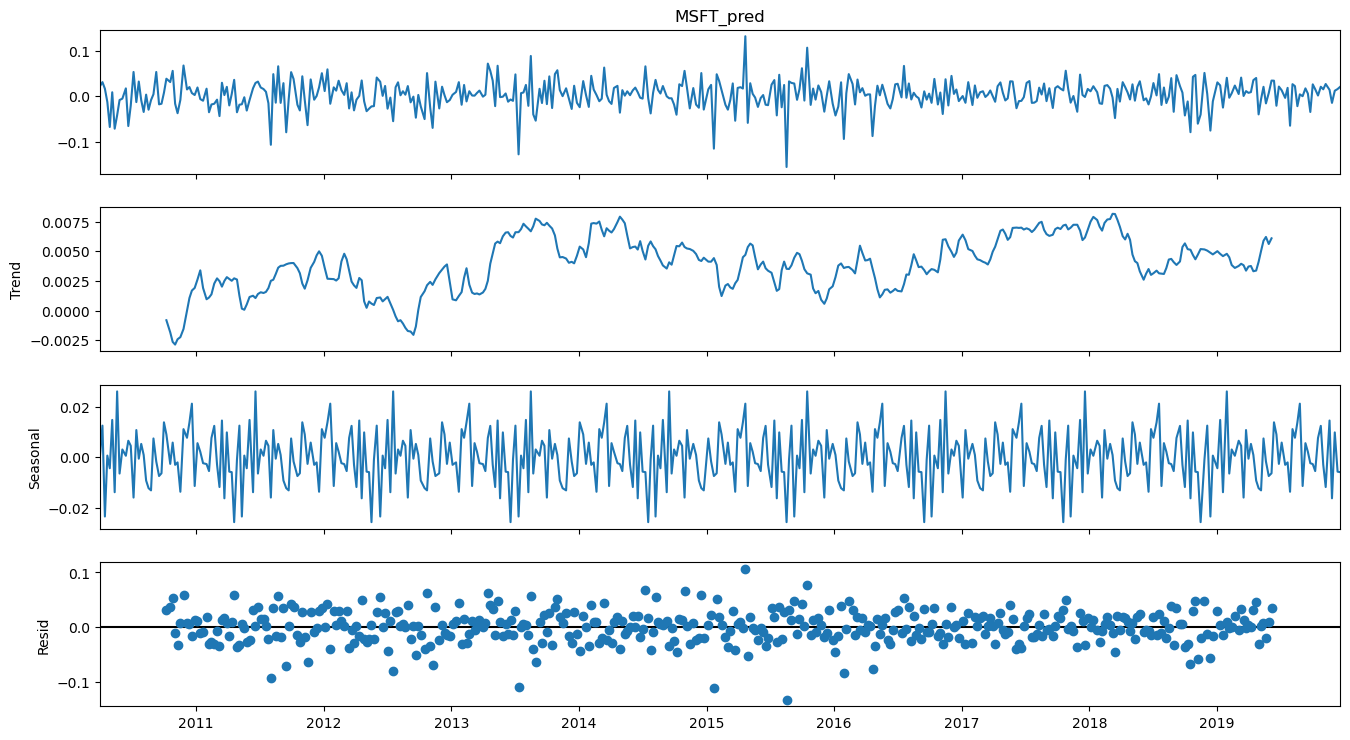

In [16]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Preparing the Data for Machine Learning Algorithms

<a id='4'></a>
# 5. Creating, Compiling, and Fitting the model

<a id='4.1'></a>
## 5.1. Train-Test Split

Next, we start by splitting our data in training and testing chunks. If we are going to use time series models we have to split the data in continous series.

In [17]:
test_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.3'></a>
## 5.2. Comparing Models and Algorithms

<a id='4.3.1'></a>
### 5.2.1 Machine Learning Models - scikit-learn

##### Linear Regression and Tree Regression Algorithms

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor()))

Once we have selected all the models, we loop over each of them. We run the model on the entire training and testing dataset.

In [19]:
names = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f %f" % (name, train_result, test_result)
    print(msg)

LR: 0.000976 0.000755
CART: 0.000000 0.001502


#### Training and Test Error

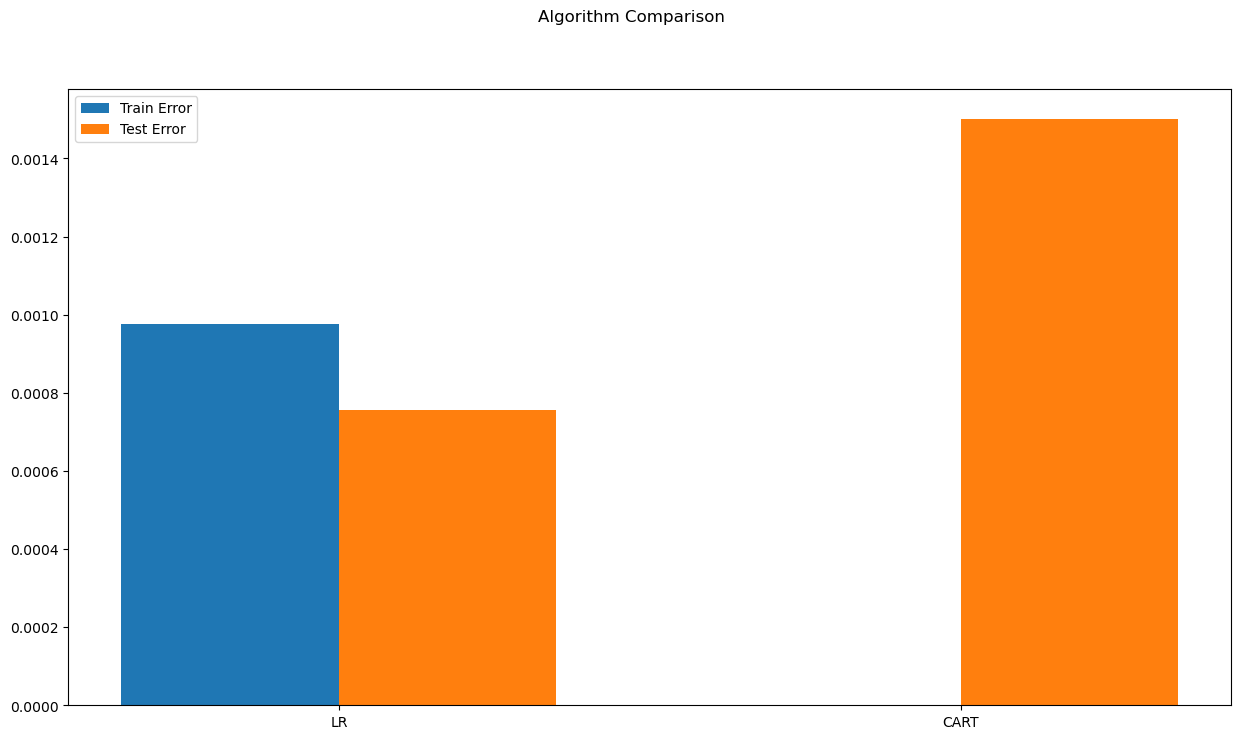

In [20]:
# Compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we see a better performance of the linear models. The decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided.

<a id='4.3.1'></a>
### 5.2.2 Time Series Based Deep Learning Models - LSTM

In [21]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [22]:
X_train_LSTM.shape

(372, 2, 11)

In [34]:
# LSTM Network

model = Sequential()
model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model.add(Dense(1))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12451 (48.64 KB)
Trainable params: 12451 (48.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


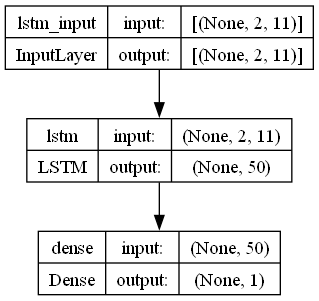

In [25]:
keras.utils.plot_model(model, show_shapes=True)

In [26]:
model.compile(loss='mse', optimizer='adam')
LSTMModel_fit = model.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

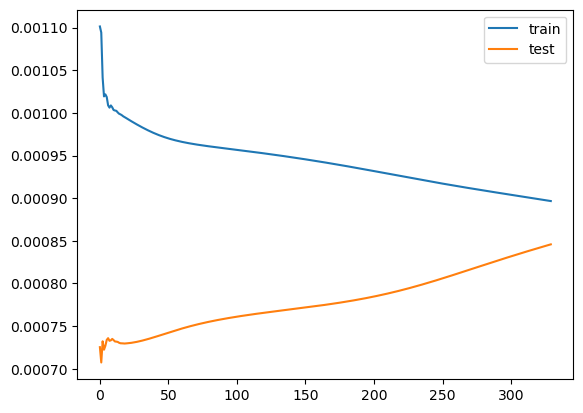

In [27]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, model.predict(X_train_LSTM))
predicted = model.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

3/3 [==============================] - 0s 6ms/step


#### Append to previous results

In [29]:
test_results.append(error_Test_LSTM)
train_results.append(error_Training_LSTM)

names.append("LSTM")

## Overall Comparison of all the Algorithms (including Time Series Algorithms)

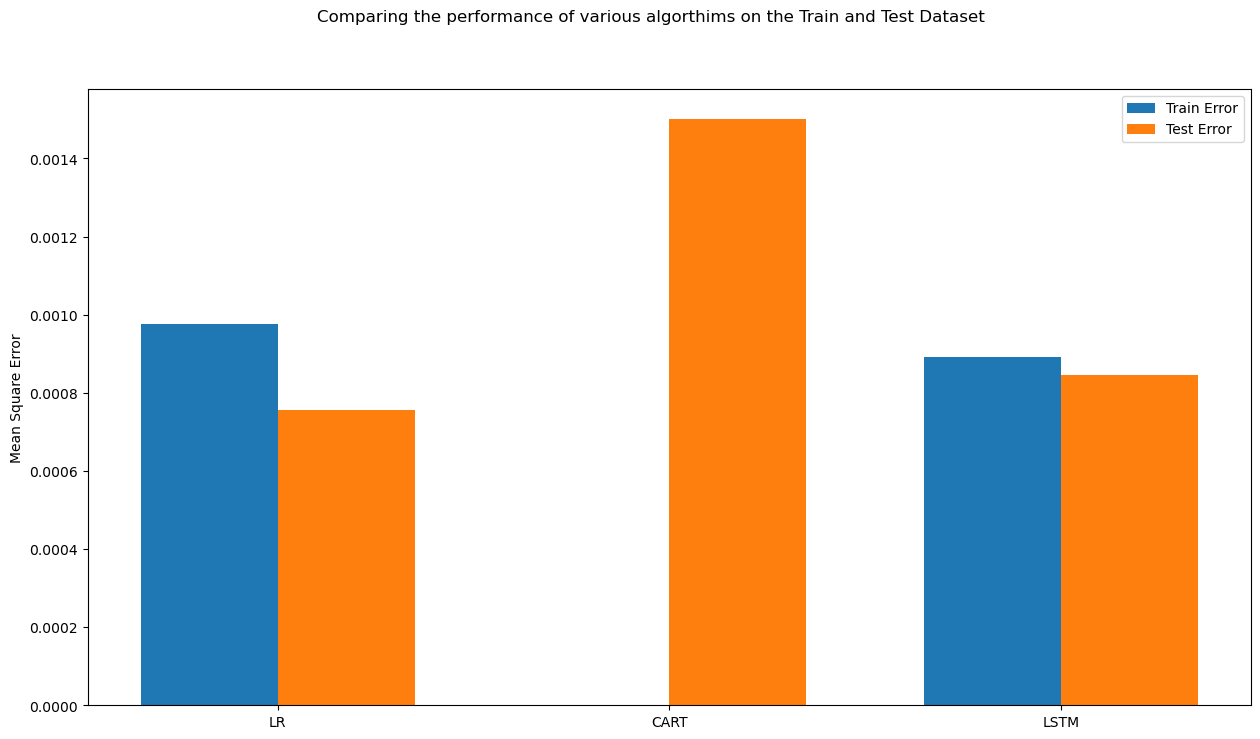

In [30]:
# Compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

<a id='6'></a>
# 6. Using the Model to Make Predictions

<a id='6.1'></a>
## 6.1. Results on the Test Dataset

In [31]:
# Estimate accuracy on test set
predicted = model.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

3/3 [==============================] - 0s 6ms/step
0.0008458631969091339


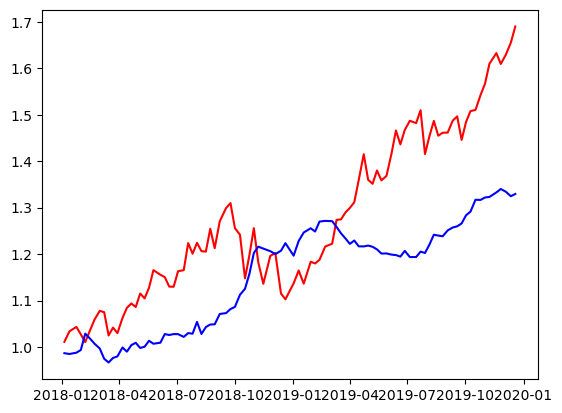

In [32]:
# Use the following code to produce the comparison of actual vs. predicted
predicted = pd.DataFrame(predicted)
predicted.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8, 6)
pyplot.show()